In [1]:
# https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko
# 이 튜토리얼에서는 3가지 예(기본 사항, 이미지 노이즈 제거 및 이상 감지)를 통해
# autoencoder를 소개합니다.

# autoencoder는 입력을 출력에 복사하도록 훈련된 특수한 유형의 신경망입니다.
# 예를 들어, 손으로 쓴 숫자의 이미지가 주어지면 autoencoder는 먼저 이미지를
# 더 낮은 차원의 잠재 표현으로 인코딩한 다음 잠재 표현을 다시 이미지로 디코딩합니다. 
# autoencoder는 재구성 오류를 최소화하면서 데이터를 압축하는 방법을 학습합니다.

# autoencoder에 대해 자세히 알아보려면 Ian Goodfellow, Yoshua Bengio 및 
# Aaron Courville의 딥 러닝에서 14장을 읽어보세요.

In [2]:
## TensorFlow 및 기타 라이브러리 가져오기
from ast import BitAnd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

#import autokeras as ak

In [3]:
# 데이터세트 로드하기
# y_train과 t_test는 할당하지 않는다.

# (x_train, _), (x_test, _) = fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
# Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test).
# x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data.
# y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (60000,) for the training data.
# x_test: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data.
# y_test: uint8 NumPy array of labels (integers in range 0-9) with shape (10000,) for the test data.

In [4]:
# Label	Description
# 0	T-shirt/top
# 1	Trouser
# 2	Pullover
# 3	Dress
# 4	Coat
# 5	Sandal
# 6	Shirt
# 7	Sneaker
# 8	Bag
# 9	Ankle boot

In [9]:
print("type(fashion_mnist.load_data() = ", type(fashion_mnist.load_data()))        # <class 'tuple'>
print("len(fashion_mnist.load_data()) = ", len(fashion_mnist.load_data()))         # 2

type(fashion_mnist.load_data() =  <class 'tuple'>
len(fashion_mnist.load_data()) =  2


In [10]:
print("type(fashion_mnist.load_data()[0]) = ", type(fashion_mnist.load_data()[0]))     # <class 'tuple'>
print("len(fashion_mnist.load_data()[0]) = ", len(fashion_mnist.load_data()[0]))      # 2
print("type(fashion_mnist.load_data()[1]) = ", type(fashion_mnist.load_data()[1]))     # <class 'tuple'>
print("len(fashion_mnist.load_data()[1]) = ", len(fashion_mnist.load_data()[1]))      # 2

type(fashion_mnist.load_data()[0]) =  <class 'tuple'>
len(fashion_mnist.load_data()[0]) =  2
type(fashion_mnist.load_data()[1]) =  <class 'tuple'>
len(fashion_mnist.load_data()[1]) =  2


In [11]:
print("type(fashion_mnist.load_data()[0][0]) = ", type(fashion_mnist.load_data()[0][0]))  # <class 'numpy.ndarray'>
print("fashion_mnist.load_data()[0][0].shape = ", fashion_mnist.load_data()[0][0].shape)  # (60000, 28, 28)
print("type(fashion_mnist.load_data()[0][1]) = ", type(fashion_mnist.load_data()[0][1]))  # <class 'numpy.ndarray'>
print("fashion_mnist.load_data()[0][1].shape = ", fashion_mnist.load_data()[0][1].shape)  # (60000,)

type(fashion_mnist.load_data()[0][0]) =  <class 'numpy.ndarray'>
fashion_mnist.load_data()[0][0].shape =  (60000, 28, 28)
type(fashion_mnist.load_data()[0][1]) =  <class 'numpy.ndarray'>
fashion_mnist.load_data()[0][1].shape =  (60000,)


In [12]:
print("type(fashion_mnist.load_data()[1][0]) = ", type(fashion_mnist.load_data()[1][0]))  # <class 'numpy.ndarray'>
print("fashion_mnist.load_data()[1][0].shape = ", fashion_mnist.load_data()[1][0].shape)  # (10000, 28, 28)
print("type(fashion_mnist.load_data()[1][1]) = ", type(fashion_mnist.load_data()[1][1]))  # <class 'numpy.ndarray'>
print("fashion_mnist.load_data()[1][1].shape = ", fashion_mnist.load_data()[1][1].shape)  # (10000,)

type(fashion_mnist.load_data()[1][0]) =  <class 'numpy.ndarray'>
fashion_mnist.load_data()[1][0].shape =  (10000, 28, 28)
type(fashion_mnist.load_data()[1][1]) =  <class 'numpy.ndarray'>
fashion_mnist.load_data()[1][1].shape =  (10000,)


In [9]:
# 훈련용 이미지 6만개, 테스트용 이미지 1만개, 총 7만개

In [10]:
# array 출력 생략 해제
np.set_printoptions(threshold=np.inf, linewidth=np.inf) #inf = infinity

# array 출력 생략 복원
# np.set_printoptions(threshold=1000, linewidth=75)

In [11]:
# 좀 더 자세히 살펴보기 위해서 x_train에 첫 번째 이미지 데이터를 출력했습니다.  (스크롤 주의)
print(x_train[0])
print(x_train[0].shape) # (28, 28)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

In [12]:
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ksg97031&logNo=221302568510
# 위에서 말씀한 거처럼 28 * 28 배열로 원소들이 저장되어 있고 255를 넘는 값이 없습니다.
# 이는 각각에 원소가 데이터에 기본단위인 Byte(8 bit)로 표현됐기 때문에 0~255 사이에 값으로만 표현됩니다.
# 1 bit = 0, 1 => 2가지 값을 가질 수 있다.
# 2 bit = 00, 01, 10, 11 => 2^2=4가지 값을 가질 수 있다.
# 8 bit = 00 00 00 00 ~ 11 11 11 11 => 2^8=256가지 값을 가질 수 있다.
# Byte = 주소지정이 가능한 단일 저장소(데이터 파일의 크기)

# (이미지든, 동영상 파일이든 데이터로 된 모든 파일은 기본 단위인 Byte로 표현됩니다. )
# 0~255 중 최대 범위인 255는 우리가 표준으로 사용하는 10진수이며 
# 다른 진수 표현으론 16 진수 = 0xff, 8 진수 = 377입니다.

# 2진수(0 과 1) = binary or Bit
# 컴퓨터는 8개단위의 비트(8bit)를 하나의 그룹으로 사용하는데 이를 바이트(Byte)라 한다.
# (8bit=1Byte)

# 1Byte = 8bit = 2^8 = 256 = 0~255
# Byte는 주소 지정이 가능한 단일 저장소이다.(데이터 파일의 크기)

In [13]:
# 타입을 바꾸는(astype) 함수를 통해 실수화(float) 된 후 255로 나누어지는(/) 코드가 있습니다.
# astype('float32') 코드를 통해 실수화해줍니다.
# 실수 화가 되면 정수 뒤에 "정수. 0"처럼 '.0'이 붙거나 "정수. "처럼 생략됩니다
# 0~255 값을 0~1사이로 변경해주는 것입니다.(float32로 정규화)
#  https://hdongle.tistory.com/47
#  사이즈는 더 커짐
#  딥러닝에 넣을 때, 정규화해서 넣어야 더 잘된다고 함
#  0~255면 값이 너무 커서 학습이 잘 이뤄지지 않는다고 함
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train[0])

print (x_train.shape) # (60000, 28, 28)
print (x_test.shape)  # (10000, 28, 28)

[[0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        

In [14]:
# 첫 번째 예: 기본 autoencoder
# 두 개의 Dense 레이어로 autoencoder를 정의합니다.
# 이미지를 64차원 잠재 벡터로 압축하는 encoder와 
# 잠재 공간에서 원본 이미지를 재구성하는 decoder입니다.
# latent: 잠재, Dimension: 크기, 차원
latent_dim = 64 

In [15]:
# Keras
# https://www.tensorflow.org/guide/keras/sequential_model?hl=ko


# 클래스를 계산기로 보면 계산기가 여려대 필요할때 계산기를 여려개 만들지 않고
# 계산기 클래스로 만든 객체를 여려개 만들어 사용하면 독립적으로 사용할 수 있다.
# 클래스로 만든 객체를 해당 클래스의 인스턴스라고 한다.
# 클래스를 상속하여 만들기위해서는 class 클래스 이름(상속할 클래스 이름)
# 아래 Class Autoencoder은 Model Class(tf.keras.Model)를 상속받아 만든 클래스 이다.

In [16]:
class Autoencoder(Model):
  # 클래스로 객체 a를 만들고 객체a 가 메서드를 호출하면 메서드의 첫 번째 매개변수 
  # self에는 메서드를 호출한 객체a가 자동으로 전달된다.

  # class안에 생성된 함수를 method(메서드)라고 한다.
  # method 중에 __init__ method를 constructor(생성자)라고 한다.
  # 객체에 초깃값을 설정할 필요가 있을때는 생성자__init__를 사용하여 메서드를 만든다.
  # 생성자 __init__ 는 객체가 생성되는 시점에 자동으로 호출된다.
  def __init__(self, encoding_dim):
    print("__init__ called")
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    # 케라스는 Sequential을 사용하여 층을 차례대로 쌓습니다.  tf.keras.Sequential
    self.encoder = tf.keras.Sequential([
      # Flatten: 납작해지다
      # tf.keras.layers.Flatten은 입력을 1차원으로 변환합니다., Batch의 크기에는 영향을 주지 않습니다.
      # 입력의 형태가 (None, 28, 28)일 때, (None, 784)로 변환됩니다.
      layers.Flatten(),
      
      # Dense: 밀집한
      # tf.keras.layers.Dense는 일반적인 완전 연결된 (densely-connected, fully-connected) 신경망 층입니다.

      # <활성화 함수>
      # 이에 대한 해결책이 바로 활성화 함수(activation function)이다. 
      # 활성화 함수를 사용하면 입력값에 대한 출력값이 linear하게 나오지 않으므로
      # 선형분류기를 비선형 시스템으로 만들 수 있다.
      # * 따라서 MLP(Multiple layer perceptron)는 단지 linear layer를 여러개 쌓는 개념이 아닌 
      # 활성화 함수를 이용한 non-linear 시스템을 여러 layer로 쌓는 개념이다.
      # relu 함수는 x가 양수면 자기 자신을 반환하고, 음수면 0을 반환한다.
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  # __call__은 인스턴스가 호출되었을 때 실행 되는 것이다.
  # tf.keras.Model.call => Calls the model on new inputs and returns the outputs as tensors.
  # call(inputs, training=None, mask=None)
  def call(self, x):
    print("\n call method called")
    encoded = self.encoder(x)
    print("self.encoder(x) called")
    decoded = self.decoder(encoded)
    print("self.decoder(encoded) called")
    return decoded

In [17]:
# autoencoder는 object(객체)이다.
# autoencoder object는 Autoencoder Class의 instance 이다.
print("before autoencoder obejec creation")
autoencoder = Autoencoder(latent_dim)
print("after autoencoder obejec creation")

before autoencoder obejec creation
__init__ called
after autoencoder obejec creation


In [18]:
# cost function: 비용함수, 목적함수, 손실함수: 예측값과 식제값의 차이: MSE
# Optimizer: 옵티마이저: 비용함수를 최소화 하는 매개변수인 W와 b를 찾기위해 사용되는 알고리즘:
#            옵티마이저를 통해 적절한 W와 b를 찾아내는 과정을 머신러닝에서 학습(training)이라고 한다.
#            경사하강법(Gradient Descent): W(x축)의 변화에 따른 Cost(y축)을 줄이기 위함
# tf.keras.Model.compile => Configures the model for training.

print("\n before autoencoder.compile()")
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
print("\n after autoencoder.compile()")


 before autoencoder.compile()

 after autoencoder.compile()


In [19]:
# x_train을 입력과 대상으로 사용하여 모델을 훈련합니다. 
# encoder는 데이터세트를 784차원에서 잠재 공간으로 압축하는 방법을 배우고,
# decoder는 원본 이미지를 재구성하는 방법을 배웁니다.

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10

 call method called
self.encoder(x) called
self.decoder(encoded) called

 call method called
self.encoder(x) called
self.decoder(encoded) called
1842/1875 [============================>.] - ETA: 0s - loss: 0.0244
 call method called
self.encoder(x) called
self.decoder(encoded) called
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0242 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0118 - val_loss: 0.0110
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0089 - val_loss: 0.0089


In [20]:
# CPU 학습
# print("CPU를 사용한 학습")
# with tf.device("/device:CPU:0"):
#   autoencoder.fit(x_train, x_train,
#                   epochs=10,
#                   shuffle=True,
#                   validation_data=(x_test, x_test))

In [21]:
# print("GPU를 사용한 학습")
# with tf.device("/device:GPU:0"):
#   autoencoder.fit(x_train, x_train,
#                   epochs=10,
#                   shuffle=True,
#                   validation_data=(x_test, x_test))

In [22]:
# encoder의 요약을 살펴보겠습니다. 
# 이미지가 28x28에서 7x7로 어떻게 다운샘플링되는지 확인하세요.
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


In [23]:
# decoder는 이미지를 7x7에서 28x28로 다시 업샘플링합니다.
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 모델이 훈련되었으므로 테스트 세트에서 이미지를 인코딩 및 디코딩하여 테스트해 보겠습니다.
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

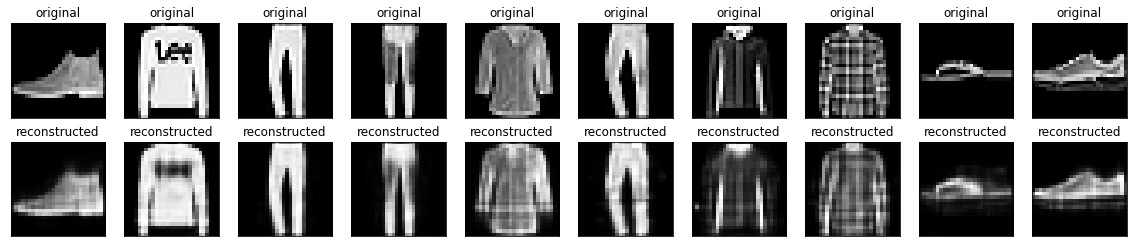

In [25]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()